# 🤖 Transformer Mimarisi - Adım Adım Rehber

Bu notebook, **"Attention Is All You Need"** (Vaswani et al., 2017) makalesindeki Transformer mimarisini adım adım, görselleştirmeler ve örneklerle açıklar.

## İçindekiler

1. [Giriş ve Motivasyon](#1-giriş-ve-motivasyon)
2. [Scaled Dot-Product Attention](#2-scaled-dot-product-attention)
3. [Multi-Head Attention](#3-multi-head-attention)
4. [Positional Encoding](#4-positional-encoding)
5. [Feed-Forward Network](#5-feed-forward-network)
6. [Encoder Layer](#6-encoder-layer)
7. [Decoder Layer](#7-decoder-layer)
8. [Tam Transformer Modeli](#8-tam-transformer-modeli)
9. [Eğitim Örneği](#9-eğitim-örneği)
10. [Inference (Text Generation)](#10-inference-text-generation)

In [2]:
# Gerekli kütüphaneleri yükle
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan cihaz: {device}")
print(f"✅ PyTorch versiyon: {torch.__version__}")

✅ Kullanılan cihaz: cuda
✅ PyTorch versiyon: 2.9.1+cu128


---
# 1. Giriş ve Motivasyon

## Transformer Neden Önemli?

Transformer öncesi modeller (RNN, LSTM) **sıralı** çalışıyordu:
- Her token bir öncekinin işlenmesini beklemek zorundaydı
- Uzun cümlelerde bilgi kaybı oluyordu
- Paralel işleme mümkün değildi

**Transformer'ın çözümü:** Attention mekanizması ile tüm tokenlere aynı anda bakabilme!

In [3]:
# Örnek: Self-Attention kavramı
cumle = ["Kedi", "süt", "içti", "çünkü", "o", "açtı"]

print("Örnek cümle:", " ".join(cumle))
print("\n'o' kelimesi için attention dağılımı (örnek):")
print("─" * 40)

# Simüle edilmiş attention skorları
attention_scores = {
    "Kedi": 0.65,   # En yüksek - "o" büyük ihtimalle "Kedi"ye referans
    "süt": 0.10,
    "içti": 0.08,
    "çünkü": 0.02,
    "o": 0.05,
    "açtı": 0.10
}

for kelime, skor in attention_scores.items():
    bar = "█" * int(skor * 30)
    print(f"{kelime:8} {bar} {skor:.2f}")

Örnek cümle: Kedi süt içti çünkü o açtı

'o' kelimesi için attention dağılımı (örnek):
────────────────────────────────────────
Kedi     ███████████████████ 0.65
süt      ███ 0.10
içti     ██ 0.08
çünkü     0.02
o        █ 0.05
açtı     ███ 0.10


---
# 2. Scaled Dot-Product Attention

## Temel Formül

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

## Q, K, V Nedir?

| Matris | Anlam | Soru |
|--------|-------|------|
| **Q** (Query) | Ne arıyorum? | "Ben hangi bilgiyi istiyorum?" |
| **K** (Key) | Ben neyim? | "Ben ne tür bir bilgiyim?" |
| **V** (Value) | İçeriğim ne? | "Benim gerçek değerim ne?" |

In [4]:
def scaled_dot_product_attention(Q, K, V, mask=None, verbose=False):
    """
    Scaled Dot-Product Attention
    
    Args:
        Q: Query [batch_size, num_heads, seq_len, d_k]
        K: Key [batch_size, num_heads, seq_len, d_k]
        V: Value [batch_size, num_heads, seq_len, d_v]
        mask: Opsiyonel attention mask
    """
    d_k = Q.size(-1)
    
    # Adım 1: QK^T
    scores = torch.matmul(Q, K.transpose(-2, -1))
    if verbose: print(f"  📊 Adım 1 - QK^T sonucu: {scores.shape}")
    
    # Adım 2: Scale
    scores = scores / math.sqrt(d_k)
    if verbose: print(f"  📊 Adım 2 - Scale faktörü: √{d_k} = {math.sqrt(d_k):.2f}")
    
    # Adım 3: Mask (opsiyonel)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
        if verbose: print(f"  📊 Adım 3 - Mask uygulandı")
    
    # Adım 4: Softmax
    attention_weights = F.softmax(scores, dim=-1)
    if verbose: print(f"  📊 Adım 4 - Softmax sonrası: her satır toplamı = 1")
    
    # Adım 5: V ile çarp
    output = torch.matmul(attention_weights, V)
    if verbose: print(f"  📊 Adım 5 - Çıktı shape: {output.shape}")
    
    return output, attention_weights

print("✅ scaled_dot_product_attention fonksiyonu tanımlandı")

✅ scaled_dot_product_attention fonksiyonu tanımlandı


In [5]:
# Örnek: Basit Attention Hesaplaması
batch_size, num_heads, seq_len, d_k = 1, 1, 3, 4

torch.manual_seed(42)
Q = torch.randn(batch_size, num_heads, seq_len, d_k)
K = torch.randn(batch_size, num_heads, seq_len, d_k)
V = torch.randn(batch_size, num_heads, seq_len, d_k)

print("="*50)
print("🔍 SCALED DOT-PRODUCT ATTENTION ÖRNEĞİ")
print("="*50)
print(f"\nGiriş boyutları: Q, K, V = {Q.shape}")
print("\nAttention hesaplanıyor...\n")

output, weights = scaled_dot_product_attention(Q, K, V, verbose=True)

print("\n📈 Attention Ağırlıkları:")
tokens = ["Token_0", "Token_1", "Token_2"]
weights_np = weights.squeeze().detach().numpy()

for i, row in enumerate(weights_np):
    print(f"{tokens[i]:10} -> {[f'{v:.3f}' for v in row]}  Σ = {row.sum():.3f}")

🔍 SCALED DOT-PRODUCT ATTENTION ÖRNEĞİ

Giriş boyutları: Q, K, V = torch.Size([1, 1, 3, 4])

Attention hesaplanıyor...

  📊 Adım 1 - QK^T sonucu: torch.Size([1, 1, 3, 3])
  📊 Adım 2 - Scale faktörü: √4 = 2.00
  📊 Adım 4 - Softmax sonrası: her satır toplamı = 1
  📊 Adım 5 - Çıktı shape: torch.Size([1, 1, 3, 4])

📈 Attention Ağırlıkları:
Token_0    -> ['0.302', '0.310', '0.388']  Σ = 1.000
Token_1    -> ['0.245', '0.380', '0.375']  Σ = 1.000
Token_2    -> ['0.294', '0.229', '0.477']  Σ = 1.000


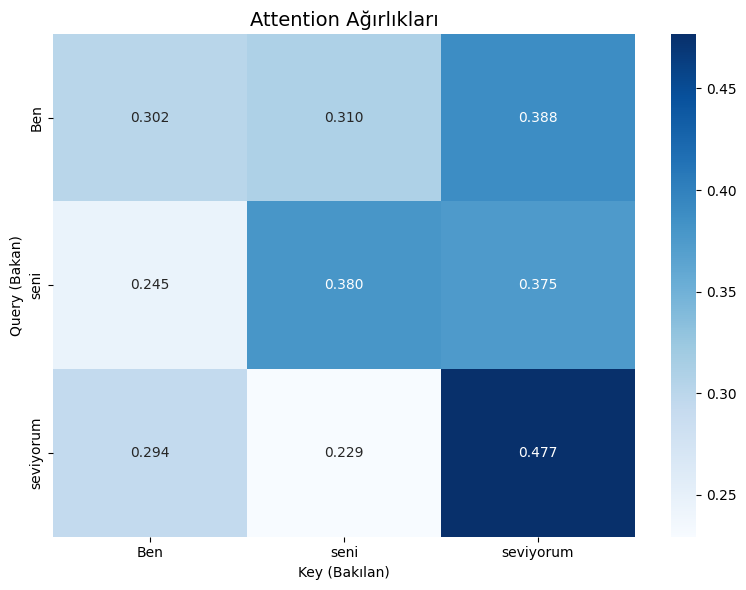

💡 Her satır bir token'ın diğer tokenlere ne kadar baktığını gösterir


In [6]:
# Attention Heatmap Görselleştirmesi
fig, ax = plt.subplots(figsize=(8, 6))

tokens = ["Ben", "seni", "seviyorum"]
sns.heatmap(weights_np, 
            xticklabels=tokens, 
            yticklabels=tokens,
            annot=True, 
            fmt='.3f', 
            cmap='Blues',
            ax=ax)
ax.set_title('Attention Ağırlıkları', fontsize=14)
ax.set_xlabel('Key (Bakılan)')
ax.set_ylabel('Query (Bakan)')
plt.tight_layout()
plt.show()

print("💡 Her satır bir token'ın diğer tokenlere ne kadar baktığını gösterir")

---
# 3. Multi-Head Attention

## Neden Birden Fazla Head?

Farklı head'ler farklı ilişkileri öğrenebilir:
- Head 1: Özne-yüklem ilişkisi
- Head 2: Sıfat-isim ilişkisi
- Head 3: Zamir referansları

## Formül

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^O$$

In [7]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention Layer"""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model % num_heads == 0 olmalı!"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projeksiyonlar
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 1. Linear projeksiyonlar
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # 2. Head'lere ayır: [batch, seq, d_model] -> [batch, heads, seq, d_k]
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 3. Attention
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        self.attention_weights = attention_weights
        
        attn_output = torch.matmul(attention_weights, V)
        
        # 4. Concat: [batch, heads, seq, d_k] -> [batch, seq, d_model]
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)
        
        # 5. Output projection
        output = self.W_o(attn_output)
        
        return output, attention_weights

print("✅ MultiHeadAttention sınıfı tanımlandı")

✅ MultiHeadAttention sınıfı tanımlandı


In [8]:
# Multi-Head Attention örneği
d_model, num_heads, seq_len, batch_size = 512, 8, 6, 2

mha = MultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)

output, weights = mha(x, x, x)  # Self-attention

print(f"Giriş: {x.shape}")
print(f"Çıktı: {output.shape}")
print(f"Attention weights: {weights.shape} (batch, heads, seq, seq)")
print(f"d_k (her head): {d_model // num_heads}")
print(f"Toplam parametre: {sum(p.numel() for p in mha.parameters()):,}")

Giriş: torch.Size([2, 6, 512])
Çıktı: torch.Size([2, 6, 512])
Attention weights: torch.Size([2, 8, 6, 6]) (batch, heads, seq, seq)
d_k (her head): 64
Toplam parametre: 1,050,624


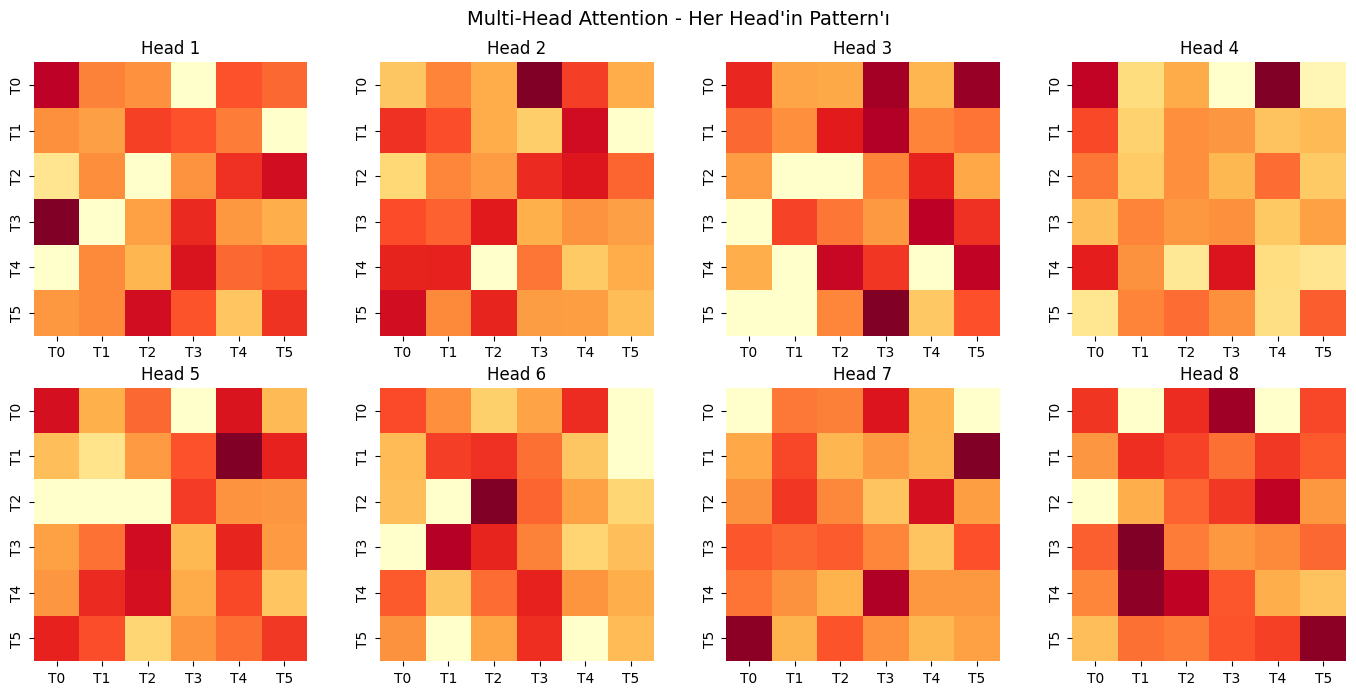

💡 Her head farklı pattern'lara dikkat edebilir!


In [9]:
# Her Head'in Attention Pattern'ını Görselleştirme
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Multi-Head Attention - Her Head\'in Pattern\'ı', fontsize=14)

tokens = [f"T{i}" for i in range(seq_len)]
weights_np = weights[0].detach().numpy()

for idx, ax in enumerate(axes.flat):
    sns.heatmap(weights_np[idx], xticklabels=tokens, yticklabels=tokens,
                cmap='YlOrRd', ax=ax, cbar=False, square=True)
    ax.set_title(f'Head {idx + 1}')

plt.tight_layout()
plt.show()

print("💡 Her head farklı pattern'lara dikkat edebilir!")

---
# 4. Positional Encoding

## Problem
Attention mekanizması pozisyon bilgisi taşımaz!

## Çözüm: Sinüzoidal Encoding

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

In [ ]:
class PositionalEncoding(nn.Module):
    """Sinüzoidal Positional Encoding"""
    
    def __init__(self, d_model, max_seq_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)  # Çift indeksler
        pe[:, 1::2] = torch.cos(position * div_term)  # Tek indeksler
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

print("✅ PositionalEncoding sınıfı tanımlandı")

In [ ]:
# Positional Encoding Görselleştirmesi
pe = PositionalEncoding(d_model=128, max_seq_len=100)
pe_values = pe.pe.squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
im = axes[0].imshow(pe_values[:50, :64], aspect='auto', cmap='RdBu_r')
axes[0].set_xlabel('Embedding Boyutu')
axes[0].set_ylabel('Pozisyon')
axes[0].set_title('Positional Encoding Heatmap')
plt.colorbar(im, ax=axes[0])

# Sin/cos dalgaları
for dim in [0, 10, 20, 30]:
    axes[1].plot(pe_values[:50, dim], label=f'dim={dim}')
axes[1].set_xlabel('Pozisyon')
axes[1].set_ylabel('Encoding Değeri')
axes[1].set_title('Farklı Boyutlardaki Dalgalar')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# 5. Feed-Forward Network

$$\text{FFN}(x) = \text{ReLU}(xW_1 + b_1)W_2 + b_2$$

- İç boyut (d_ff) genelde d_model'in 4 katı
- Her pozisyon için bağımsız uygulanır

In [ ]:
class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network"""
    
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

# Test
ff = FeedForward(512, 2048)
x = torch.randn(2, 10, 512)
print(f"FFN: {x.shape} -> {ff(x).shape}")
print(f"Parametre: {sum(p.numel() for p in ff.parameters()):,}")

---
# 6. Encoder Layer

```
Input → Self-Attention → Add & Norm → FFN → Add & Norm → Output
```

In [ ]:
class EncoderLayer(nn.Module):
    """Tek bir Encoder Layer"""
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-Attention + Residual + Norm
        attn_output, attn_weights = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-Forward + Residual + Norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attn_weights

# Test
enc_layer = EncoderLayer(512, 8, 2048)
x = torch.randn(2, 10, 512)
out, _ = enc_layer(x)
print(f"Encoder Layer: {x.shape} -> {out.shape}")

---
# 7. Decoder Layer

Encoder'dan farkı:
- **Masked** Self-Attention (gelecek tokenleri göremez)
- **Cross-Attention** (Encoder'a bak)

In [ ]:
class DecoderLayer(nn.Module):
    """Tek bir Decoder Layer"""
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Masked Self-Attention
        attn_output, _ = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Cross-Attention (Q: decoder, K,V: encoder)
        attn_output, cross_weights = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        
        # Feed-Forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x, cross_weights

print("✅ DecoderLayer tanımlandı")

In [ ]:
# Causal Mask Görselleştirmesi
def generate_causal_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return (mask == 0).float()

mask = generate_causal_mask(6)

plt.figure(figsize=(6, 5))
sns.heatmap(mask.numpy(), annot=True, fmt='.0f', cmap='RdYlGn',
            xticklabels=[f"T{i}" for i in range(6)],
            yticklabels=[f"T{i}" for i in range(6)])
plt.title('Causal Mask\n(1 = bakabilir, 0 = bakamaz)')
plt.xlabel('Key')
plt.ylabel('Query')
plt.show()

print("💡 Her token sadece kendinden önceki tokenlere bakabilir!")

---
# 8. Tam Transformer Modeli

In [ ]:
class Transformer(nn.Module):
    """Tam Transformer Modeli"""
    
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8,
                 num_layers=6, d_ff=2048, max_seq_len=5000, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len, dropout)
        
        # Encoder & Decoder
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        
        # Output
        self.output_linear = nn.Linear(d_model, tgt_vocab_size)
        
    def generate_causal_mask(self, size, device):
        mask = torch.triu(torch.ones(size, size, device=device), diagonal=1) == 0
        return mask.unsqueeze(0).unsqueeze(0)
    
    def encode(self, src, src_mask=None):
        x = self.src_embedding(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.encoder_layers:
            x, _ = layer(x, src_mask)
        return x
    
    def decode(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        x = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        for layer in self.decoder_layers:
            x, _ = layer(x, encoder_output, src_mask, tgt_mask)
        return x
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        if tgt_mask is None:
            tgt_mask = self.generate_causal_mask(tgt.size(1), tgt.device)
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        return self.output_linear(decoder_output)

print("✅ Transformer sınıfı tanımlandı")

In [ ]:
# Model Oluşturma
config = {'src_vocab_size': 10000, 'tgt_vocab_size': 10000, 'd_model': 512,
          'num_heads': 8, 'num_layers': 6, 'd_ff': 2048}

transformer = Transformer(**config)

# Test
src = torch.randint(1, 10000, (4, 20))
tgt = torch.randint(1, 10000, (4, 25))
output = transformer(src, tgt)

print(f"🤖 TRANSFORMER MODELİ")
print(f"="*50)
print(f"Kaynak: {src.shape}")
print(f"Hedef: {tgt.shape}")
print(f"Çıktı: {output.shape}")
print(f"Toplam parametre: {sum(p.numel() for p in transformer.parameters()):,}")

---
# 9. Eğitim Örneği

In [ ]:
def train_step(model, src, tgt, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    
    # Teacher forcing
    tgt_input = tgt[:, :-1]
    tgt_output = tgt[:, 1:]
    
    logits = model(src, tgt_input)
    loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    return loss.item()

# Küçük model ile demo
small_transformer = Transformer(1000, 1000, d_model=128, num_heads=4, num_layers=2, d_ff=512)
optimizer = torch.optim.Adam(small_transformer.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Eğitim
src_sample = torch.randint(1, 1000, (8, 15))
tgt_sample = torch.randint(1, 1000, (8, 20))

print("🎓 EĞİTİM DEMOSU")
losses = []
for step in range(30):
    loss = train_step(small_transformer, src_sample, tgt_sample, optimizer, criterion)
    losses.append(loss)
    if (step + 1) % 10 == 0:
        print(f"Step {step+1}: Loss = {loss:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Eğitim Loss')
plt.grid(True, alpha=0.3)
plt.show()

---
# 10. Inference (Text Generation)

In [ ]:
def greedy_decode(model, src, max_len, start_token, end_token):
    """Greedy decoding ile sequence üret"""
    model.eval()
    
    with torch.no_grad():
        encoder_output = model.encode(src)
        tgt = torch.tensor([[start_token]])
        
        generated = [start_token]
        
        for _ in range(max_len):
            tgt_mask = model.generate_causal_mask(tgt.size(1), tgt.device)
            decoder_output = model.decode(tgt, encoder_output, tgt_mask=tgt_mask)
            logits = model.output_linear(decoder_output[:, -1, :])
            
            next_token = logits.argmax(dim=-1).item()
            generated.append(next_token)
            
            if next_token == end_token:
                break
            
            tgt = torch.cat([tgt, torch.tensor([[next_token]])], dim=1)
    
    return generated

# Test
src_test = torch.randint(1, 1000, (1, 10))
generated = greedy_decode(small_transformer, src_test, max_len=15, start_token=1, end_token=2)

print("🔮 INFERENCE ÖRNEĞİ")
print(f"Kaynak: {src_test.squeeze().tolist()}")
print(f"Üretilen: {generated}")
print("\n(Not: Model eğitilmediği için çıktı anlamsız)")

---
# 📚 Özet

| Bileşen | Açıklama |
|---------|----------|
| **Scaled Dot-Product Attention** | Q, K, V ile attention hesaplama |
| **Multi-Head Attention** | Paralel attention head'ler |
| **Positional Encoding** | Sin/cos ile pozisyon bilgisi |
| **Feed-Forward** | 2 katmanlı MLP |
| **Encoder** | Self-Attention + FFN |
| **Decoder** | Masked Self-Attention + Cross-Attention + FFN |

## Kaynaklar
- [Attention Is All You Need (2017)](https://arxiv.org/abs/1706.03762)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)